In [58]:
# 일단 2015데이터로 학습, 예측

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import numpy  as np
import seaborn as sns
%matplotlib inline

path = './data/'
pd.options.display.max_rows = 150
pd.options.display.max_columns = 350
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [2]:
sido = pd.read_csv(path+'sido_imp_10.csv', encoding='cp949')

In [3]:
sido_y = sido.iloc[:,-7:]
sido_x = sido.iloc[:,3:-7]
sido_name = sido.iloc[:,:3]

### 표준화

In [4]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
sido_x_scaled = scaler.fit_transform(sido_x)

In [5]:
sido_x_scaled = pd.DataFrame(data = sido_x_scaled)
sido_x_scaled.columns = sido_x.columns
sido_x_scaled.shape

(17, 163)

### 전체변수 넣고 다양한 알고리즘을 실험해보자

스코어나오는 함수 설정

In [85]:
#교차검증 실험 crossvalscore이용
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
cv = KFold(3, shuffle=True, random_state=0)
def KFold_meanscore(ary):
    tot = 0
    for i in ary:
        tot += i
    return print(tot/len(ary),ary)
def kfold_crossvalscore(model, X, y, cv=cv):
    ary1 = cross_val_score(model, X, y, cv=cv, scoring='f1')
    ary2 = cross_val_score(model, X, y, cv=cv, scoring='accuracy')
    ary3 = cross_val_score(model, X, y, cv=cv, scoring='precision')
    ary4 = cross_val_score(model, X, y, cv=cv, scoring='recall')
    print(f'f1-score:{KFold_meanscore(ary1)}')
    print(f'accuracy:{KFold_meanscore(ary2)}')
    print(f'precision:{KFold_meanscore(ary3)}')
    print(f'recall:{KFold_meanscore(ary4)}')

In [82]:
#분류메트릭이용
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

def metric_score(y = sido.감염병, pred = pred):
    print(f'f1 :\t\t{f1_score(y,pred)}')
    print(f'accuracy :\t{accuracy_score(y,pred)}')
    print(f'precision :\t{precision_score(y, pred)}')
    print(f'recall :\t{recall_score(y, pred)}')

In [56]:
#정답지 출력
def paper(y, pred=pred):
    a = pd.DataFrame(data=pred,columns=['예측'])
    b = pd.DataFrame(data=y)
    return pd.concat([a,b],axis=1)

# MLP

In [69]:
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(hidden_layer_sizes=(50,30))
mlp.fit(sido_x_scaled, sido.감염병)
pred_mlp = mlp.predict(sido_x_scaled)

In [70]:
mlp.score(sido_x_scaled, sido.감염병) #모델에 트레이닝셋을 적용했을때 평균정확도(accuracy) 반환

1.0

In [72]:
confusion_matrix = pd.crosstab(sido.감염병, pred_mlp, rownames=['True'], colnames=['Predicted'], margins=True)
confusion_matrix

Predicted,0,1,All
True,,,
0,11,0,11
1,0,6,6
All,11,6,17


In [86]:
#crossvalscore이용
kfold_crossvalscore(mlp, sido_x_scaled, sido.감염병)

C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.43333333333333335 [0.5 0.  0.8]
f1-score:None
0.7666666666666666 [0.66666667 0.83333333 0.8       ]
accuracy:None
0.4444444444444444 [0.33333333 0.         1.        ]
precision:None
0.38888888888888884 [0.5        0.         0.66666667]
recall:None


In [83]:
#분류메트릭이용
metric_score(sido.감염병, pred_mlp)

f1 :		1.0
accuracy :	1.0
precision :	1.0
recall :	1.0


In [76]:
#classification report
from sklearn.metrics import classification_report
print(classification_report(sido.감염병,pred_mlp, target_names=['123','45']))

              precision    recall  f1-score   support

         123       1.00      1.00      1.00        11
          45       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



In [77]:
#정답지
paper(sido.감염병, pred_mlp)

,예측,감염병
0,0,0
1,0,0
2,0,0
3,1,1
4,0,0
5,1,1
6,0,0
7,1,1
8,0,0
9,1,1


# RFC

In [62]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=10).fit(sido_x_scaled, sido.감염병)
rfc.fit(sido_x_scaled, sido.감염병)
pred_rfc = rfc.predict(sido_x_scaled)

# XGB

In [90]:
from xgboost import XGBClassifier
xgb = XGBClassifier(max_depth=10, n_estimators=200, learning_rate=0.01)
xgb.fit(sido_x_scaled, sido.감염병)
pred_xgb = xgb.predict(sido_x_scaled)

# LGBM

In [64]:
from lightgbm import LGBMClassifier

In [65]:
import copy#lgbm은 아스키 코드값만 입력받기 때문에 한글을 다 숫자로 바뀌주기
lgbm_sido = b = copy.deepcopy(sido_x_scaled) 
lgbm_sido.columns = list(range(163))
lgbm= LGBMClassifier(n_estimators=200,num_boost_round =500,learning_rate =0.01)
lgbm.fit(lgbm_sido, sido.감염병)
pred_lgbm = lgbm.predict(sido_x_scaled)

C:\Anaconda3\lib\site-packages\lightgbm\engine.py:148: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


# SVC

In [66]:
from sklearn.svm import SVC
svc = SVC(gamma=0.0001, C=3000, probability=True)
svc.fit(sido_x_scaled, sido.감염병)
pred_svc = svc.predict(sido_x_scaled)

In [68]:
print(classification_report(sido.감염병,pred_svc, target_names=['123','45']))

              precision    recall  f1-score   support

         123       1.00      1.00      1.00        11
          45       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



# Logistic Regression

In [79]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(sido_x_scaled, sido.감염병)
pred_lr = lr.predict(sido_x_scaled)

C:\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [80]:
print(classification_report(sido.감염병,pred_lr, target_names=['123','45']))

              precision    recall  f1-score   support

         123       1.00      1.00      1.00        11
          45       1.00      1.00      1.00         6

    accuracy                           1.00        17
   macro avg       1.00      1.00      1.00        17
weighted avg       1.00      1.00      1.00        17



# Decision Tree

In [81]:
from sklearn.linear_model import Perceptron
pcp = Perceptron()
pcp.fit(sido_x_scaled, sido.감염병)
pred_pcp = pcp.predict(sido_x_scaled)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier()
dtc.fit(sido_x_scaled, sido.감염병)
pred_dtc = pcp.predict(sido_x_scaled)

# AUC / ROC

In [93]:
#AUC: AreaUnderCurve는 1에 가까울 수록 좋음
from sklearn.metrics import roc_curve
fpr1, tpr1, thresholds1 = roc_curve(sido.감염병, lr.decision_function(sido_x_scaled))
fpr2, tpr2, thresholds2 = roc_curve(sido.감염병, svc.decision_function(sido_x_scaled))
#no mlp, xgb

In [94]:
from sklearn.metrics import auc
auc(fpr1,tpr1), auc(fpr2, tpr2)
#auc of model1, auc of model2

(1.0, 1.0)

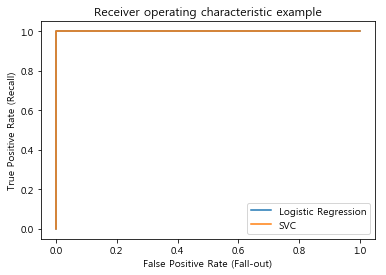

In [105]:
#roc커브 시각화
plt.title('Receiver operating characteristic example')
plt.xlabel('False Positive Rate (Fall-out)')
plt.ylabel('True Positive Rate (Recall)')
plt.plot(fpr1, tpr1, label='Logistic Regression')
plt.plot(fpr2, tpr2, label='SVC')
plt.legend()

plt.plot([0,0],[1,1],'k--',label='random gu ess') ## 수정해야됨